In [40]:
import os
import json

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

In [41]:
def get_file_name(model_type, plot_dict):
    nation = plot_dict['nation']
    task_type = plot_dict['task_type']
    
    if model_type in ['ARIMA', 'LR', 'SVR']:
        file_name = os.path.join('weights', model_type, nation, f'{task_type}.json')
        return file_name
    if model_type == 'STGP':
        model_dict = plot_dict['STGP']
        kernel_name = model_dict['kernel_name']
        num_mixture = model_dict['num_mixture']
        setting_name = f'{kernel_name}-2020-02-27-0.01-{num_mixture}'
        file_name = os.path.join('weights', model_type, setting_name, nation, f'{task_type}.json')
        return file_name
    if model_type == 'MTGP':
        model_dict = plot_dict['MTGP']
        rank = model_dict['rank']
        kernel_name = model_dict['kernel_name']
        num_mixture = model_dict['num_mixture']
        setting_name = f'{kernel_name}-{rank}-2020-02-27-0.01-{num_mixture}'
        file_name = os.path.join('weights', model_type, setting_name, nation, f'{task_type}.json')
        return file_name
    if model_type == 'ours':
        model_dict = plot_dict['ours']
        mtl_name = model_dict['mtl']
        rank = model_dict['rank']
        kernel_name = model_dict['kernel_name']
        num_mixture = model_dict['num_mixture']
        dkl_layers = model_dict['dkl_layers']
        emb_dim = model_dict['emb_dim']
        setting_name = f'{kernel_name}-0.01-0.0-{num_mixture}-{rank}-{emb_dim}-{dkl_layers}'
        file_name = os.path.join('weights', model_type, mtl_name, setting_name, nation, f'{task_type}.json')
        return file_name
    
    if model_type == 'gcformer':
        raise NotImplementedError

def get_grid_days(dates, start_date, pred_end_date):
    train_date = dates[0]
    valid_date = dates[1]
    test_date = dates[2]
    pred_date = dates[3]
    
    days = pd.date_range(start=start_date, end=pred_end_date, freq='D').values.astype('datetime64[D]')
    # first_day_of_month = pd.date_range(start=start_date, end=pred_end_date, freq='MS').values.astype('datetime64[D]')
    first_day_of_year = pd.date_range(start=start_date, end=pred_end_date, freq='YS').values.astype('datetime64[D]')  # Changed to 'YS' for year start

    days_list = []
    color_list = []
    cnt = 0
    # for i, day in enumerate(days):
    #     if day in first_day_of_month:
    #         if cnt % 12 == 0:
    #             if i == 3:
    #                 continue
    #             days_list.append(i)
    #             color_list.append('black')
    #         cnt += 1
    # for i, day in enumerate(days):
        # if day in first_day_of_year:  # Check if the day is the first day of the year
            # days_list.append(i)
            # color_list.append('black')
    # train/valid/test days
    train_start = int(np.where(days == np.datetime64(train_date[0]))[0])
    valid_start = int(np.where(days == np.datetime64(valid_date[0]))[0])
    test_start = int(np.where(days == np.datetime64(test_date[0]))[0])
    pred_start = int(np.where(days == np.datetime64(pred_date[0]))[0])
    pred_end = int(np.where(days == np.datetime64(pred_date.iloc[-1]))[0])
    days_list.append(train_start)
    color_list.append('black')
    days_list.append(valid_start)
    color_list.append('black')
    days_list.append(test_start)
    color_list.append('black')
    days_list.append(pred_start)
    color_list.append('black')
    days_list.append(pred_end)
    color_list.append('black')

    days_list, color_list = zip(*sorted(zip(days_list, color_list)))
    return days_list, color_list

def plot_gp(all_mean, upper_list, lower_list, ori_y_list, nation, nation_plot_root, max_value, type_, dates, epoch, start_date, pred_end_date, color_, ax, model_type, linewidth):
    ori_train_y = ori_y_list[0]
    ori_valid_y_cpu = ori_y_list[1]
    ori_test_y = ori_y_list[2]

    train_date = dates[0]
    valid_date = dates[1]
    test_date = dates[2]
    pred_date = dates[3]

    all_date = pd.concat([train_date, valid_date, test_date, pred_date]).reset_index(drop=True)
    days_list, color_list = get_grid_days(dates, start_date, pred_end_date)
    days_list = list(days_list)
    plt.rcParams.update({'font.size': 25})
    
    max_value = max(max(ori_train_y), max(ori_valid_y_cpu), max(ori_test_y), max_value)
    ax.set_ylim([-0.1 * max_value, 1.01 * max_value])
    
    ax.plot(train_date, ori_train_y, linewidth=linewidth, color='darkgrey')
    ax.plot(valid_date, ori_valid_y_cpu, linewidth=linewidth, color='darkgrey')
    ax.plot(test_date, ori_test_y, linewidth=linewidth, color='darkgrey')
    ax.plot(all_date, all_mean, color_, linewidth=linewidth)
    # # confidence region 시각화
    # if model_type in ['STGP', 'MTGP', 'ours']:
    #     ori_train_upper = upper_list[0]
    #     ori_valid_upper = upper_list[1]
    #     ori_test_upper = upper_list[2]
    #     ori_pred_upper = upper_list[3]

    #     ori_train_lower = lower_list[0]
    #     ori_valid_lower = lower_list[1]
    #     ori_test_lower = lower_list[2]
    #     ori_pred_lower = lower_list[3]
    #     ori_lower = ori_train_lower + ori_valid_lower + ori_test_lower + ori_pred_lower
    #     ori_upper = ori_train_upper  + ori_valid_upper  + ori_test_upper  + ori_pred_upper 
    #     ax.fill_between(all_date, ori_lower, ori_upper, alpha=0.2, color=color_)
    #     # ax.fill_between(train_date, ori_train_lower, ori_train_upper, alpha=0.5, color=color_)
    #     # ax.fill_between(valid_date, ori_valid_lower, ori_valid_upper, alpha=0.5, color=color_)
    #     # ax.fill_between(test_date, ori_test_lower, ori_test_upper, alpha=0.5, color=color_)
    #     # ax.fill_between(pred_date, ori_pred_lower, ori_pred_upper, alpha=0.5, color=color_)
    xticks = [all_date[day_idx] for day_idx in days_list]
    xticks[-1] = '2024-12-31'
    xticklabels = [date for date in xticks]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels, rotation=30, ha='right', va='top', fontsize=35)
    ax.tick_params(axis='y', labelsize=35)
    for color_idx, color in enumerate(color_list):
        tick = ax.get_xticklabels()[color_idx]
        tick.set_color(color)

In [42]:
start_date = '2020-02-27'
pred_end_date = '2024-12-31'

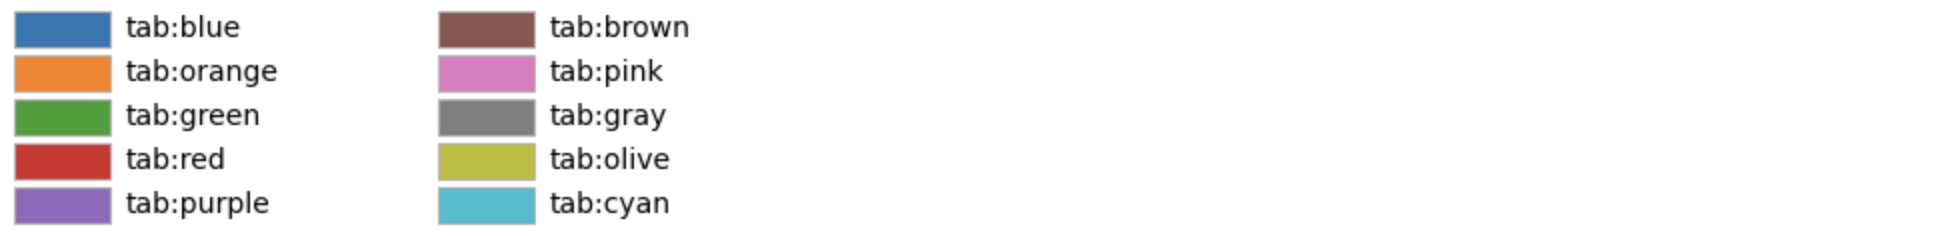

In [43]:
plot_save_root = 'final_plot'
weight_root = '/mlainas/mulan98/gp-regression/weights'

nation_list = ['japan', 'south_korea', 'taiwan']
plt.style.use('seaborn')
# ours -> MTGP -> STGP -> SVR -> LR -> ARIMA -> GCformer
color_list = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:cyan']

In [44]:
# for nation in nation_list:
#     for task_type in ['conf', 'dead']:
#         os.mkdir(os.path.join(".", plot_save_root, f'{nation}_{task_type}'))

### 1. ARIMA

In [45]:
model_type_list = ['ARIMA']
# os.mkdir(os.path.join(".", plot_save_root, model_type_list[0]))

for i, model_type in enumerate(model_type_list):
    for nation in nation_list:
        for task_type in ['conf', 'dead']:
            legend_labels = []
            f, ax = plt.subplots(1, 1, figsize=(20, 12))
            file_name = os.path.join(weight_root, model_type_list[0], nation, f'{task_type}.json')
            with open(file_name, 'r') as fp:
                json_file = json.load(fp)
            ori_train_mean = json_file['ori_train_mean']
            ori_valid_mean = json_file['ori_valid_mean']
            ori_test_mean = json_file['ori_test_mean']
            ori_pred_mean = json_file['ori_pred_mean']
            
            if model_type in ['STGP', 'MTGP', 'ours']:
                upper_list = json_file['upper_list']
                lower_list = json_file['lower_list']
            else:
                upper_list=None
                lower_list=None
            if 'ori_y_list' in json_file.keys():
                ori_y_list = json_file['ori_y_list'] 

            all_mean = np.concatenate([ori_train_mean, ori_valid_mean, ori_test_mean, ori_pred_mean])

            max_value = json_file[f'max_{task_type}']
            if 'dates' in json_file.keys():
                dates = json_file['dates']
                dates = [pd.Series(x) for x in dates]
            plot_gp(all_mean=all_mean, 
                    upper_list=upper_list,
                    lower_list=lower_list, 
                    ori_y_list=ori_y_list, 
                    nation=nation, 
                    nation_plot_root=None, 
                    max_value=max_value,
                    type_=task_type, 
                    dates=dates, 
                    epoch='-best', 
                    start_date=start_date, 
                    pred_end_date=pred_end_date,
                    color_=color_list[5],
                    ax=ax,
                    model_type=model_type,
                    linewidth=3)
            legend_labels.append((model_type, color_list[5]))
            legend_labels.append(('ground truth', 'darkgrey'))
            handles = [plt.Line2D([], [], color=color, marker='o', markersize=25, linewidth=0) for _, color in legend_labels]
            labels = [label for label, _ in legend_labels]
            plt.legend(handles, labels, loc='upper left', fontsize=40)
            plt.tight_layout()
            # f.show()
            f.savefig(os.path.join(".", plot_save_root, model_type_list[0], f'{nation}-{task_type}.png'))
            f.savefig(os.path.join(".", plot_save_root, f'{nation}_{task_type}', f'{model_type_list[0]}.png'))
            # f.savefig(f'./gp-regression/final_plot/ARIMA/{nation}-{task_type}.png')
            plt.close()

### 2. Linear Regression

In [46]:
model_name = 'LR'
model_type_list = [model_name]
# os.mkdir(os.path.join(".", plot_save_root, model_type_list[0]))

for i, model_type in enumerate(model_type_list):
    for nation in nation_list:
        for task_type in ['conf', 'dead']:
            legend_labels = []
            f, ax = plt.subplots(1, 1, figsize=(20, 12))
            file_name = os.path.join(weight_root, model_type_list[0], nation, f'{task_type}.json')
            with open(file_name, 'r') as fp:
                json_file = json.load(fp)
            ori_train_mean = json_file['ori_train_mean']
            ori_valid_mean = json_file['ori_valid_mean']
            ori_test_mean = json_file['ori_test_mean']
            ori_pred_mean = json_file['ori_pred_mean']
            
            if model_type in ['STGP', 'MTGP', 'ours']:
                upper_list = json_file['upper_list']
                lower_list = json_file['lower_list']
            else:
                upper_list=None
                lower_list=None
            if 'ori_y_list' in json_file.keys():
                ori_y_list = json_file['ori_y_list'] 

            all_mean = np.concatenate([ori_train_mean, ori_valid_mean, ori_test_mean, ori_pred_mean])

            max_value = json_file[f'max_{task_type}']
            if 'dates' in json_file.keys():
                dates = json_file['dates']
                dates = [pd.Series(x) for x in dates]
            plot_gp(all_mean=all_mean, 
                    upper_list=upper_list,
                    lower_list=lower_list, 
                    ori_y_list=ori_y_list, 
                    nation=nation, 
                    nation_plot_root=None, 
                    max_value=max_value,
                    type_=task_type, 
                    dates=dates, 
                    epoch='-best', 
                    start_date=start_date, 
                    pred_end_date=pred_end_date,
                    color_=color_list[4],
                    ax=ax,
                    model_type=model_type,
                    linewidth=3)
            legend_labels.append((model_type, color_list[4]))
            legend_labels.append(('ground truth', 'darkgrey'))
            handles = [plt.Line2D([], [], color=color, marker='o', markersize=25, linewidth=0) for _, color in legend_labels]
            labels = [label for label, _ in legend_labels]
            plt.legend(handles, labels, loc='upper left', fontsize=40)
            plt.tight_layout()
            f.savefig(os.path.join(".", plot_save_root, model_type_list[0], f'{nation}-{task_type}.png'))
            f.savefig(os.path.join(".", plot_save_root, f'{nation}_{task_type}', f'{model_type_list[0]}.png'))
            plt.close()

### 3. SVR

In [47]:
model_name = 'SVR'
model_type_list = [model_name]
# os.mkdir(os.path.join(".", plot_save_root, model_type_list[0]))

for i, model_type in enumerate(model_type_list):
    for nation in nation_list:
        for task_type in ['conf', 'dead']:
            legend_labels = []
            f, ax = plt.subplots(1, 1, figsize=(20, 12))
            file_name = os.path.join(weight_root, model_type_list[0], nation, f'{task_type}.json')
            with open(file_name, 'r') as fp:
                json_file = json.load(fp)
            ori_train_mean = json_file['ori_train_mean']
            ori_valid_mean = json_file['ori_valid_mean']
            ori_test_mean = json_file['ori_test_mean']
            ori_pred_mean = json_file['ori_pred_mean']
            
            if model_type in ['STGP', 'MTGP', 'ours']:
                upper_list = json_file['upper_list']
                lower_list = json_file['lower_list']
            else:
                upper_list=None
                lower_list=None
            if 'ori_y_list' in json_file.keys():
                ori_y_list = json_file['ori_y_list'] 

            all_mean = np.concatenate([ori_train_mean, ori_valid_mean, ori_test_mean, ori_pred_mean])

            max_value = json_file[f'max_{task_type}']
            if 'dates' in json_file.keys():
                dates = json_file['dates']
                dates = [pd.Series(x) for x in dates]
            plot_gp(all_mean=all_mean, 
                    upper_list=upper_list,
                    lower_list=lower_list, 
                    ori_y_list=ori_y_list, 
                    nation=nation, 
                    nation_plot_root=None, 
                    max_value=max_value,
                    type_=task_type, 
                    dates=dates, 
                    epoch='-best', 
                    start_date=start_date, 
                    pred_end_date=pred_end_date,
                    color_=color_list[3],
                    ax=ax,
                    model_type=model_type,
                    linewidth=3)
            legend_labels.append((model_type, color_list[3]))
            legend_labels.append(('ground truth', 'darkgrey'))
            handles = [plt.Line2D([], [], color=color, marker='o', markersize=25, linewidth=0) for _, color in legend_labels]
            labels = [label for label, _ in legend_labels]
            plt.legend(handles, labels, loc='upper left', fontsize=40)
            plt.tight_layout()
            f.savefig(os.path.join(".", plot_save_root, model_type_list[0], f'{nation}-{task_type}.png'))
            f.savefig(os.path.join(".", plot_save_root, f'{nation}_{task_type}', f'{model_type_list[0]}.png'))
            plt.close()

### 4. MTGP + ours

In [48]:
mtgp_dict = {
    'japan': '/mlainas/mulan98/gp-regression/weights/MTGP/SMP-1-2020-02-27-0.01-4/japan', 
    'south_korea': '/mlainas/mulan98/gp-regression/weights/MTGP/SM+L-1-2020-02-27-0.01-4/south_korea',
    'taiwan': '/mlainas/mulan98/gp-regression/weights/MTGP/SM+L-1-2020-02-27-0.01-3/taiwan',
}
ours_dict = {
    'japan': '/mlainas/mulan98/gp-regression/weights/ours/equal-SM+P-SM+L-SM+P/0.01-0.01-5-2-16-0/3_7_14/japan', 
    'south_korea': '/mlainas/mulan98/gp-regression/weights/ours/equal-SM+P-SM+L-SM+P/0.01-0.01-5-2-16-0/3_7_14/south_korea',
    'taiwan': '/mlainas/mulan98/gp-regression/weights/ours/equal-SM+P-SM+L-SM+P/0.01-0.01-5-2-16-0/3_7_14/taiwan'
}

In [49]:
model_type_list = ['ours', 'MTGP']
# os.mkdir(os.path.join(".", plot_save_root, model_type_list[0]))

for i, model_type in enumerate(model_type_list):
    for nation in nation_list:
        if model_type=='MTGP':
            nation_root = mtgp_dict[nation]
        else:
            nation_root = ours_dict[nation]
        for task_type in ['conf', 'dead']:
            legend_labels = []
            f, ax = plt.subplots(1, 1, figsize=(20, 12))
            file_name = os.path.join(nation_root, f'{task_type}.json')
            with open(file_name, 'r') as fp:
                json_file = json.load(fp)
            ori_train_mean = json_file['ori_train_mean']
            ori_valid_mean = json_file['ori_valid_mean']
            ori_test_mean = json_file['ori_test_mean']
            ori_pred_mean = json_file['ori_pred_mean']
            
            if model_type in ['STGP', 'MTGP', 'ours']:
                upper_list = json_file['upper_list']
                lower_list = json_file['lower_list']
            else:
                upper_list=None
                lower_list=None
            if 'ori_y_list' in json_file.keys():
                ori_y_list = json_file['ori_y_list'] 

            all_mean = np.concatenate([ori_train_mean, ori_valid_mean, ori_test_mean, ori_pred_mean])

            max_value = json_file[f'max_{task_type}']
            if 'dates' in json_file.keys():
                dates = json_file['dates']
                dates = [pd.Series(x) for x in dates]
            plot_gp(all_mean=all_mean, 
                    upper_list=upper_list,
                    lower_list=lower_list, 
                    ori_y_list=ori_y_list, 
                    nation=nation, 
                    nation_plot_root=None, 
                    max_value=max_value,
                    type_=task_type, 
                    dates=dates, 
                    epoch='-best', 
                    start_date=start_date, 
                    pred_end_date=pred_end_date,
                    color_=color_list[i],
                    ax=ax,
                    model_type=model_type,
                    linewidth=3)
            if model_type =='ours':
                legend_labels.append(('DMTGP', color_list[i]))
            else:
                legend_labels.append((model_type, color_list[i]))
            legend_labels.append(('ground truth', 'darkgrey'))
            handles = [plt.Line2D([], [], color=color, marker='o', markersize=25, linewidth=0) for _, color in legend_labels]
            labels = [label for label, _ in legend_labels]
            plt.legend(handles, labels, loc='upper left', fontsize=40)
            plt.tight_layout()
            f.savefig(os.path.join(".", plot_save_root, model_type_list[i], f'{nation}-{task_type}.png'))
            f.savefig(os.path.join(".", plot_save_root, f'{nation}_{task_type}', f'{model_type_list[i]}.png'))
            plt.close()

### 5. STGP

In [50]:
stgp_dict = {
    'japan': {
        'conf': '/mlainas/mulan98/gp-regression/weights/STGP/SM+P-2020-02-27-0.01-4/japan',
        'dead': '/mlainas/mulan98/gp-regression/weights/STGP/SM+P-2020-02-27-0.01-3/japan',
    },
    'south_korea': {
        'conf': '/mlainas/mulan98/gp-regression/weights/STGP/SMP-2020-02-27-0.01-2/south_korea',
        'dead': '/mlainas/mulan98/gp-regression/weights/STGP/SMP-2020-02-27-0.01-2/south_korea',
    },
    'taiwan': {
        'conf': '/mlainas/mulan98/gp-regression/weights/STGP/SM+P-2020-02-27-0.01-3/taiwan',
        'dead': '/mlainas/mulan98/gp-regression/weights/STGP/SM+P-2020-02-27-0.01-4/taiwan',
    },
}

In [51]:
model_name = 'STGP'
model_type_list = [model_name]
# os.mkdir(os.path.join(".", plot_save_root, model_type_list[0]))

for i, model_type in enumerate(model_type_list):
    for nation in nation_list:
        for task_type in ['conf', 'dead']:
            nation_root = stgp_dict[nation][task_type]
            legend_labels = []
            f, ax = plt.subplots(1, 1, figsize=(20, 12))
            file_name = os.path.join(nation_root, f'{task_type}.json')
            with open(file_name, 'r') as fp:
                json_file = json.load(fp)
            ori_train_mean = json_file['ori_train_mean']
            ori_valid_mean = json_file['ori_valid_mean']
            ori_test_mean = json_file['ori_test_mean']
            ori_pred_mean = json_file['ori_pred_mean']
            
            if model_type in ['STGP', 'MTGP', 'ours']:
                upper_list = json_file['upper_list']
                lower_list = json_file['lower_list']
            else:
                upper_list=None
                lower_list=None
            if 'ori_y_list' in json_file.keys():
                ori_y_list = json_file['ori_y_list'] 

            all_mean = np.concatenate([ori_train_mean, ori_valid_mean, ori_test_mean, ori_pred_mean])

            max_value = json_file[f'max_{task_type}']
            if 'dates' in json_file.keys():
                dates = json_file['dates']
                dates = [pd.Series(x) for x in dates]
            plot_gp(all_mean=all_mean, 
                    upper_list=upper_list,
                    lower_list=lower_list, 
                    ori_y_list=ori_y_list, 
                    nation=nation, 
                    nation_plot_root=None, 
                    max_value=max_value,
                    type_=task_type, 
                    dates=dates, 
                    epoch='-best', 
                    start_date=start_date, 
                    pred_end_date=pred_end_date,
                    color_=color_list[2],
                    ax=ax,
                    model_type=model_type,
                    linewidth=3)
            legend_labels.append((model_type, color_list[2]))
            legend_labels.append(('ground truth', 'darkgrey'))
            handles = [plt.Line2D([], [], color=color, marker='o', markersize=25, linewidth=0) for _, color in legend_labels]
            labels = [label for label, _ in legend_labels]
            plt.legend(handles, labels, loc='upper left', fontsize=40)
            plt.tight_layout()
            f.savefig(os.path.join(".", plot_save_root, model_type_list[0], f'{nation}-{task_type}.png'))
            f.savefig(os.path.join(".", plot_save_root, f'{nation}_{task_type}', f'{model_type_list[0]}.png'))
            plt.close()

### All Together

In [52]:
model_type_list = ['ours', 'MTGP', 'STGP', 'SVR', 'LR', 'ARIMA']
# color_list = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#ffd92f', '#e5c494', '#b3b3b3']
# color_list = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:cyan']
# os.mkdir(os.path.join(".", plot_save_root, 'all'))

for nation in nation_list:
    for task_type in ['conf', 'dead']:
        legend_labels = []
        legend_labels.append(('ground truth', 'darkgrey'))
        f, ax = plt.subplots(1, 1, figsize=(20, 12))
        for i, model_type in enumerate(model_type_list):
            if model_type == 'ours':
                nation_root = ours_dict[nation]
                file_name = os.path.join(nation_root, f'{task_type}.json')
            elif model_type == 'MTGP':
                nation_root = mtgp_dict[nation]
                file_name = os.path.join(nation_root, f'{task_type}.json')
            elif model_type == 'STGP':
                nation_root = stgp_dict[nation][task_type]
                file_name = os.path.join(nation_root, f'{task_type}.json')
            else:
                file_name = os.path.join(weight_root, model_type_list[i], nation, f'{task_type}.json')
            with open(file_name, 'r') as fp:
                json_file = json.load(fp)
            ori_train_mean = json_file['ori_train_mean']
            ori_valid_mean = json_file['ori_valid_mean']
            ori_test_mean = json_file['ori_test_mean']
            ori_pred_mean = json_file['ori_pred_mean']
            
            if model_type in ['STGP', 'MTGP', 'ours']:
                upper_list = json_file['upper_list']
                lower_list = json_file['lower_list']
            else:
                upper_list=None
                lower_list=None
            if 'ori_y_list' in json_file.keys():
                ori_y_list = json_file['ori_y_list'] 

            all_mean = np.concatenate([ori_train_mean, ori_valid_mean, ori_test_mean, ori_pred_mean])

            max_value = json_file[f'max_{task_type}']
            if 'dates' in json_file.keys():
                dates = json_file['dates']
                dates = [pd.Series(x) for x in dates]
            plot_gp(all_mean=all_mean, 
                    upper_list=upper_list,
                    lower_list=lower_list, 
                    ori_y_list=ori_y_list, 
                    nation=nation, 
                    nation_plot_root=None, 
                    max_value=max_value,
                    type_=task_type, 
                    dates=dates, 
                    epoch='-best', 
                    start_date=start_date, 
                    pred_end_date=pred_end_date,
                    color_=color_list[i],
                    ax=ax,
                    model_type=model_type,
                    linewidth=1.2)
            legend_labels.append((model_type, color_list[i]))
        handles = [plt.Line2D([], [], color=color, marker='o', markersize=25, linewidth=0) for _, color in legend_labels]
        labels = [label for label, _ in legend_labels]
        plt.legend(handles, labels, loc='upper left', fontsize=40)
        plt.tight_layout()
        f.savefig(os.path.join(".", plot_save_root, 'all', f'{nation}-{task_type}.png'))
        plt.close()